Image shape (lat, lon): (984, 1074)
Tb range: 176.5 to 197.4


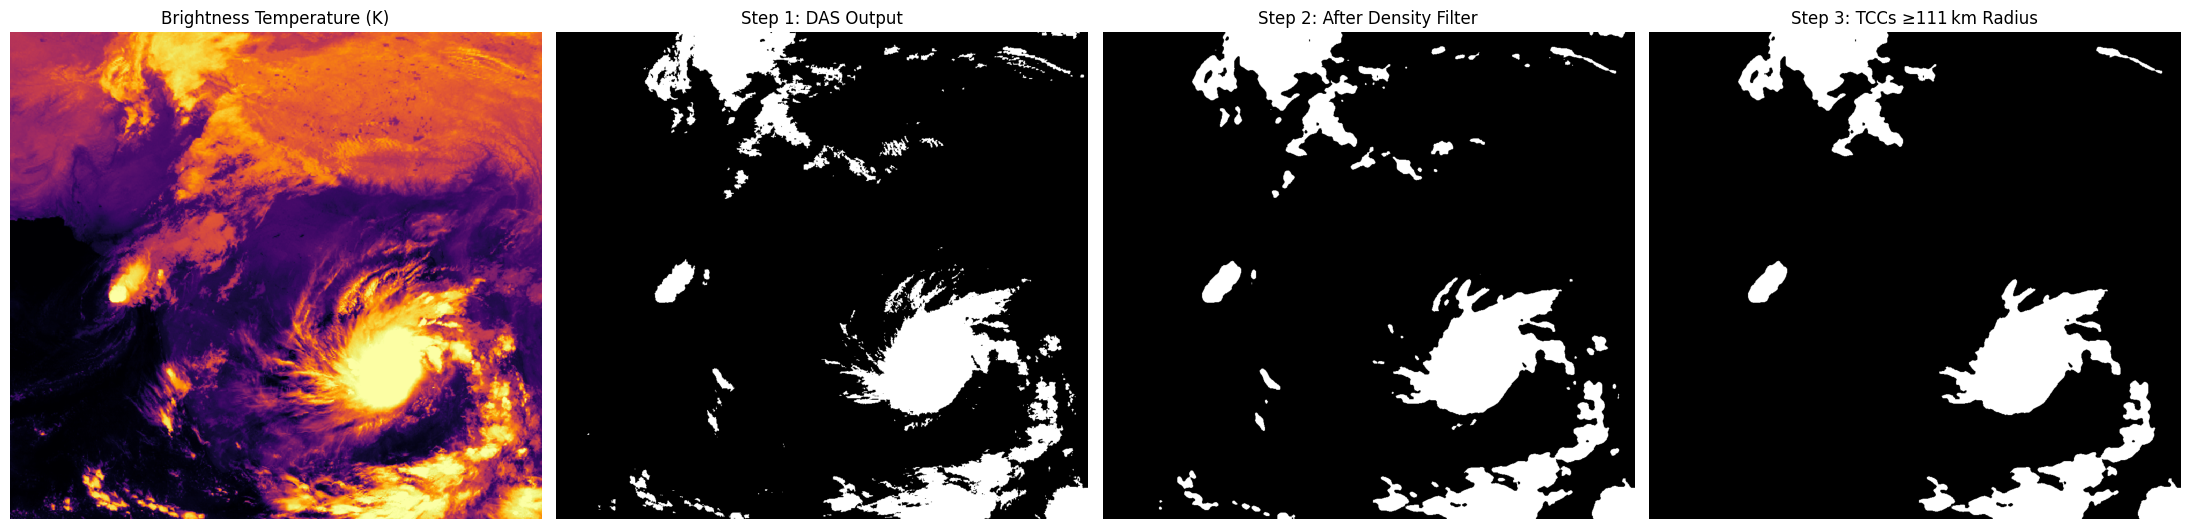

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.ndimage import uniform_filter, binary_dilation, label
from skimage.measure import regionprops

# === STEP 1: Load image and convert to Tb ===
file_path = r"C:\Users\kpmai\Maitreyee\Codes\ISRO\INSAT3D_TIR1_India\3DIMG_07NOV2019_0000_L1C_SGP.tif"
dn = np.array(Image.open(file_path)).astype(np.float32)

print("Image shape (lat, lon):", dn.shape)
tb = 0.05 * dn + 150.0
print("Tb range:", tb.min(), "to", tb.max())

# === STEP 2: Parameters (adjustable) ===
mask_lower = 190.0   # lower bound for DAS spread
mask_upper = 200.0   # upper bound for DAS spread
core_thresh = 190.5  # core of cluster
estimated_km_per_pixel = 6.0  # set this manually after inspection

# === STEP 3: Detect-and-Spread (first stage) ===
def detect_and_spread(tb, core_thresh, spread_low, spread_high, iterations=5):
    core = tb > core_thresh
    spread = (tb >= spread_low) & (tb <= spread_high)
    mask = core.copy()
    for _ in range(iterations):
        mask = binary_dilation(mask, structure=np.ones((3, 3))) & spread | core
    return mask.astype(np.uint8)

das_mask = detect_and_spread(tb, core_thresh, mask_lower, mask_upper)

# === STEP 4: Apply Temperature Density Filter to DAS output ===
density = uniform_filter(das_mask.astype(float), size=9)
density_mask = (density > 0.5).astype(np.uint8)

# === STEP 5: Filter blobs ≥ 111 km radius ===
labeled, _ = label(density_mask)
min_radius_km = 111
min_area_pixels = np.pi * (min_radius_km / estimated_km_per_pixel)**2

valid_mask = np.zeros_like(das_mask)
for region in regionprops(labeled):
    if region.area >= min_area_pixels:
        valid_mask[labeled == region.label] = 1

# === STEP 6: Visualize in correct flow order ===
fig, axs = plt.subplots(1, 4, figsize=(22, 6))

axs[0].imshow(tb, cmap='inferno', vmin=np.percentile(tb, 2), vmax=np.percentile(tb, 98))
axs[0].set_title("Brightness Temperature (K)")
axs[0].axis('off')

axs[1].imshow(das_mask, cmap='gray')
axs[1].set_title("Step 1: DAS Output")
axs[1].axis('off')

axs[2].imshow(density_mask, cmap='gray')
axs[2].set_title("Step 2: After Density Filter")
axs[2].axis('off')

axs[3].imshow(valid_mask, cmap='gray')
axs[3].set_title("Step 3: TCCs ≥111 km Radius")
axs[3].axis('off')

plt.tight_layout()
plt.show()

Detected TCC Properties:
   label  pixel_count  centroid_lat  centroid_lon     mean_tb      min_tb  \
0      1      26225.0     59.333499    335.108942  192.250748  186.649994   
1      2       1138.0     50.162566    956.379613  190.882065  187.649994   
2      3       1139.0     81.955224    550.301141  190.328751  186.000000   
3      4       8329.0    173.782087    447.475207  190.957611  188.050003   
4      5       3653.0    506.963592    239.295100  193.174988  188.449997   
5      6      47170.0    647.748336    770.307462  193.852386  184.399994   
6      7      29837.0    897.605222    846.079633  193.133789  184.199997   
7      8       2263.0    941.672117    582.687141  192.058731  185.300003   
8      9       5081.0    952.232041   1035.118874  193.397263  185.600006   

       max_tb  bbox-0  bbox-1  bbox-2  bbox-3   radius_km  mean_radius_km  \
0  194.250000       0     180     159     487  548.193728      334.715127   
1  192.899994      30     903      84    1036  114

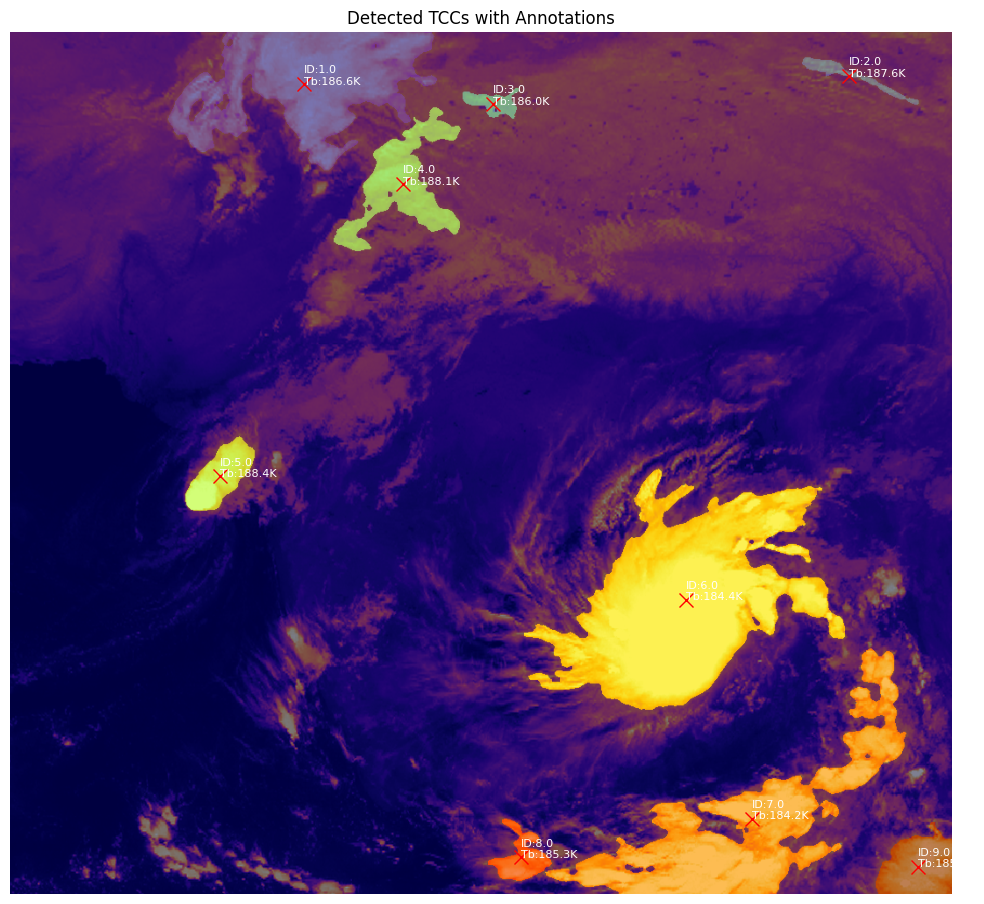

In [4]:
import pandas as pd
import json
from skimage.measure import regionprops_table

# === STEP 7: Extract Properties of Detected TCCs ===
def extract_tcc_properties(tb, valid_mask, km_per_pixel=6.0):
    labeled_mask, num_clusters = label(valid_mask)
    props = regionprops_table(
        labeled_mask, 
        intensity_image=tb,
        properties=(
            'label', 'area', 'centroid', 
            'intensity_mean', 'intensity_min', 
            'intensity_max', 'bbox'
        )
    )
    
    # Convert to DataFrame
    df = pd.DataFrame(props)
    
    # Calculate additional metrics
    df['radius_km'] = np.sqrt(df['area'] / np.pi) * km_per_pixel
    df['mean_radius_km'] = df['radius_km'].mean()
    df['std_dev_tb'] = df.apply(
        lambda row: np.std(tb[(labeled_mask == row['label']) & (valid_mask == 1)]), 
        axis=1
    )
    
    # Rename columns for clarity
    df.rename(columns={
        'centroid-0': 'centroid_lat',
        'centroid-1': 'centroid_lon',
        'intensity_mean': 'mean_tb',
        'intensity_min': 'min_tb',
        'intensity_max': 'max_tb',
        'area': 'pixel_count'
    }, inplace=True)
    
    return df, labeled_mask

# Extract properties
tcc_properties, labeled_mask = extract_tcc_properties(tb, valid_mask, estimated_km_per_pixel)

# Display the extracted properties
print("Detected TCC Properties:")
print(tcc_properties)

# === STEP 8: Save Outputs ===
# Option 1: Save as CSV
tcc_properties.to_csv('tcc_properties.csv', index=False)

# Option 2: Save as GeoJSON (for GIS applications)
def df_to_geojson(df, output_file='tcc_properties.geojson'):
    features = []
    for _, row in df.iterrows():
        feature = {
            "type": "Feature",
            "geometry": {
                "type": "Point",
                "coordinates": [row['centroid_lon'], row['centroid_lat']]
            },
            "properties": {
                "label": int(row['label']),
                "pixel_count": int(row['pixel_count']),
                "mean_tb": float(row['mean_tb']),
                "min_tb": float(row['min_tb']),
                "max_tb": float(row['max_tb']),
                "radius_km": float(row['radius_km']),
                "std_dev_tb": float(row['std_dev_tb'])
            }
        }
        features.append(feature)
    
    geojson = {
        "type": "FeatureCollection",
        "features": features
    }
    
    with open(output_file, 'w') as f:
        json.dump(geojson, f, indent=4)

df_to_geojson(tcc_properties)

# Option 3: Save the labeled mask (for further analysis)
Image.fromarray(labeled_mask.astype(np.uint16)).save('labeled_tcc_mask.tif')

# === STEP 9: Visualize Annotations ===
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(tb, cmap='inferno', vmin=np.percentile(tb, 2), vmax=np.percentile(tb, 98))
ax.imshow(labeled_mask, cmap='jet', alpha=0.5)  # Overlay labeled clusters
ax.set_title("Detected TCCs with Annotations")
ax.axis('off')

# Plot centroids
for _, row in tcc_properties.iterrows():
    ax.plot(row['centroid_lon'], row['centroid_lat'], 'rx', markersize=10)
    ax.text(row['centroid_lon'], row['centroid_lat'], 
            f"ID:{row['label']}\nTb:{row['min_tb']:.1f}K", 
            color='white', fontsize=8)

plt.tight_layout()
plt.show()

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.ndimage import uniform_filter, binary_dilation, label
from skimage.measure import regionprops, regionprops_table
import pandas as pd
import json
import cv2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sort import Sort  # For tracking (install: `pip install filterpy`)

# ==================================================================
# PART 1: LOAD AND PREPROCESS DATA (YOUR EXISTING CODE)
# ==================================================================
def load_and_preprocess(file_path):
    """Load satellite image and convert to brightness temperature (Tb)."""
    dn = np.array(Image.open(file_path)).astype(np.float32)
    tb = 0.05 * dn + 150.0  # Calibration formula
    return tb

# ==================================================================
# PART 2: DEEP LEARNING SEGMENTATION (U-NET) - NEW ADDITION
# ==================================================================
def unet(input_size=(256, 256, 1)):
    """U-Net model for cloud segmentation."""
    inputs = Input(input_size)
    
    # Downsample
    conv1 = Conv2D(64, 3, activation="relu", padding="same")(inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation="relu", padding="same")(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    # Bottleneck
    conv3 = Conv2D(256, 3, activation="relu", padding="same")(pool2)
    
    # Upsample
    up1 = UpSampling2D(size=(2, 2))(conv3)
    concat1 = concatenate([conv2, up1], axis=-1)
    conv4 = Conv2D(128, 3, activation="relu", padding="same")(concat1)
    
    up2 = UpSampling2D(size=(2, 2))(conv4)
    concat2 = concatenate([conv1, up2], axis=-1)
    conv5 = Conv2D(64, 3, activation="relu", padding="same")(concat2)
    
    outputs = Conv2D(1, 1, activation="sigmoid")(conv5)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

def train_unet(tb_image, annotated_mask, epochs=20):
    """Train U-Net using augmented data from a single annotated mask."""
    # Data augmentation
    datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode="reflect",
    )
    
    # Generate synthetic data
    augmented_images = []
    augmented_masks = []
    for _ in range(100):
        for batch_img, batch_mask in datagen.flow(
            np.expand_dims(tb_image, axis=(0, -1)), 
            np.expand_dims(annotated_mask, axis=(0, -1)),
            batch_size=1,
        ):
            augmented_images.append(batch_img[0])
            augmented_masks.append(batch_mask[0])
            break
    
    X_train = np.array(augmented_images)
    y_train = np.array(augmented_masks)
    
    # Train model
    model = unet(input_size=(tb_image.shape[0], tb_image.shape[1], 1))
    model.fit(X_train, y_train, epochs=epochs, batch_size=4)
    return model

# ==================================================================
# PART 3: TCC DETECTION AND TRACKING (INTEGRATED PIPELINE)
# ==================================================================
def detect_tccs(tb, model=None, classical_mode=True, core_thresh=190.5, mask_lower=190.0, mask_upper=200.0):
    """Detect TCCs using either classical CV or U-Net."""
    if classical_mode:
        # Classical CV approach (your existing code)
        das_mask = detect_and_spread(tb, core_thresh, mask_lower, mask_upper)
        density = uniform_filter(das_mask.astype(float), size=9)
        valid_mask = (density > 0.5).astype(np.uint8)
    else:
        # Deep learning approach
        pred_mask = model.predict(np.expand_dims(tb, axis=(0, -1)) > 0.5).astype(np.uint8)
        valid_mask = pred_mask[0, :, :, 0]
    
    return valid_mask

def track_tccs_across_frames(tcc_properties_list, max_distance_km=1200, km_per_pixel=6.0):
    """Track TCCs across multiple timesteps using SORT algorithm."""
    tracker = Sort(max_age=3, min_hits=1)
    tracks = {}
    
    for frame_idx, df in enumerate(tcc_properties_list):
        detections = []
        for _, row in df.iterrows():
            # Convert centroid to detection format [x1, y1, x2, y2] (dummy width/height)
            x, y = row['centroid_lon'], row['centroid_lat']
            detections.append([x, y, x + 10, y + 10])  # Dummy bbox
        
        if detections:
            tracked_objects = tracker.update(np.array(detections))
            
            for obj in tracked_objects:
                track_id = int(obj[4])
                if track_id not in tracks:
                    tracks[track_id] = []
                tracks[track_id].append({
                    'frame': frame_idx,
                    'centroid': (obj[0], obj[1]),
                    'properties': df.iloc[int(obj[4]) % len(df)].to_dict()
                })
    
    return tracks

# ==================================================================
# PART 4: MAIN EXECUTION (EXAMPLE USAGE)
# ==================================================================
if __name__ == "__main__":
    # Load data
    file_path = r"C:\Users\kpmai\Maitreyee\Codes\ISRO\INSAT3D_TIR1_India\3DIMG_07NOV2019_0000_L1C_SGP.tif"
    tb = load_and_preprocess(file_path)
    
    # Option 1: Classical CV approach
    valid_mask = detect_tccs(tb, classical_mode=True)
    
    # Option 2: Deep learning approach (if annotated mask is available)
    # annotated_mask = np.array(Image.open("cloud_mask.png")).astype(np.uint8)
    # model = train_unet(tb, annotated_mask)
    # valid_mask = detect_tccs(tb, model=model, classical_mode=False)
    
    # Extract properties
    tcc_properties, labeled_mask = extract_tcc_properties(tb, valid_mask)
    print("Detected TCCs:\n", tcc_properties)
    
    # Save outputs
    tcc_properties.to_csv('tcc_properties.csv', index=False)
    df_to_geojson(tcc_properties)
    
    # Visualize
    plt.imshow(tb, cmap='inferno')
    plt.imshow(labeled_mask, cmap='jet', alpha=0.5)
    plt.scatter(tcc_properties['centroid_lon'], tcc_properties['centroid_lat'], c='red', s=10)
    plt.title("Detected TCCs")
    plt.show()
    
    # Example of tracking across multiple frames
    # Assume `tcc_properties_list` is a list of DataFrames from consecutive timesteps
    # tracks = track_tccs_across_frames(tcc_properties_list)

ImportError: DLL load failed while importing lapack_lite: The specified module could not be found.

In [3]:
import rasterio

file = "3DIMG_07NOV2019_0200_L1C_SGP.tif"

with rasterio.open(file) as src:
    print("Driver:", src.driver)
    print("Width:", src.width)
    print("Height:", src.height)
    print("CRS:", src.crs)
    print("Transform:", src.transform)
    print("Count (bands):", src.count)
    print("Tags:", src.tags())


Driver: GTiff
Width: 1074
Height: 984
CRS: EPSG:4326
Transform: | 0.03, 0.00, 62.99|
| 0.00,-0.03, 38.03|
| 0.00, 0.00, 1.00|
Count (bands): 1
Tags: {'AREA_OR_POINT': 'Area'}


In [4]:
import rasterio

with rasterio.open("3DIMG_07NOV2019_0200_L1C_SGP.tif") as src:
    print("Dimensions:", src.width, "x", src.height)


Dimensions: 1074 x 984


In [6]:
import rasterio
import numpy as np

with rasterio.open("3DIMG_07NOV2019_0200_L1C_SGP.tif") as src:
    dn = src.read(1)
    print("Data Type:", dn.dtype)
    print("Min DN:", np.nanmin(dn))
    print("Max DN:", np.nanmax(dn))
    print("Unique DNs:", np.unique(dn)[0:10])


Data Type: float32
Min DN: 519.0
Max DN: 937.0
Unique DNs: [519. 520. 522. 523. 524. 525. 526. 527. 528. 529.]


In [7]:
import rasterio
import numpy as np
import pandas as pd

# Planck constants
h = 6.6260755e-34
c = 2.9979246e8
k = 1.380658e-23
C1 = 2 * h * c**2
C2 = h * c / k

# TIR2 coefficients
a, b, c0 = 0.0, 0.102, 0.0
central_wavelength = 12.0  # µm

# Read the raw DN
with rasterio.open("3DIMG_07NOV2019_0200_L1C_SGP.tif") as src:
    dn = src.read(1).astype(np.float32)
    dn = np.where(dn == src.nodata, np.nan, dn)

# Step 1: Convert DN to Radiance
rad = a * dn**2 + b * dn + c0  # in mW/cm²/sr/µm

# Step 2: Convert Radiance to SI units (W/m²/sr/m)
rad_si = rad * 10  # mW/cm²/µm → W/m²/µm
cwl = central_wavelength * 1e-6  # µm → meters

# Step 3: Convert Radiance to Brightness Temperature (BT)
with np.errstate(divide='ignore', invalid='ignore'):
    bt = C2 / (cwl * np.log((C1 / (rad_si * cwl**5)) + 1))

# Save BT to CSV
pd.DataFrame(bt).to_csv("INSAT3D_TIR2_BT_K.csv", index=False, header=False)


In [ ]:
import cv2
import matplotlib.pyplot as plt

# Read the TIFF file (OpenCV reads it as BGR by default)
img = cv2.imread('your_file.tif', cv2.IMREAD_UNCHANGED)

# Convert BGR to RGB for correct visualization
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Display the image
plt.imshow(img_rgb)
plt.axis('off')
plt.show()

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (1190785379.py, line 5)